# Dark Frame Calibration

In [39]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from tifffile import imwrite


import sys
sys.path.append('../../tauSWIRcamera')  # Add the path to the directory containing file_to_import.py
from tauSWIRcamera import tauSWIRcamera

plt.rcParams["font.family"] = "Times New Roman"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
hostname = '129.123.5.125'
port = 4000
cam = tauSWIRcamera("Industrial", hostname, port)
cameraFolder = "CAM1"
saveTIFdata = True

Running setup script - Gain Mode: low


## Data Acquisition

In [47]:
def runDarkFrameAnalysis(gain, N=50):
    ### Set gain ###
    cam.setSensorGain(gain)

    # Integration time vector
    intTime_ms = np.linspace(1,30,30)
    intTime_ms = np.insert(intTime_ms, 0, 0.011)

    # FPA possible setpoint temperatures
    FPA_temp_setpoint_options = [0, 20, 40, 45] #oC

    # Load bias frame
    # bias_frame = Image.open(f"../bias_frame/{cameraFolder}/bias_frame_{gain}_{FPA_setPointTemp}C_{cameraFolder}.tif")
    # # Convert the PIL image to a NumPy array
    # bias_frame = np.array(bias_frame)


    fig, ax = plt.subplots()
    marker = {20: '-o', 40:'-s'}
    color = {20: 'blue',40:'red'}
    for fpaTemp in [20, 40]:
        # Set FPA setpoint temp
        print(f"Set FPA temp to {fpaTemp}oC")
        cam.setFPATempSetPoint(FPA_temp_setpoint_options.index(fpaTemp))
        df_mean  = np.array([])
        df_mean_estimated = np.array([])
        df_std  = np.array([])
        df_estimated_std = np.array([])
        for t_ms in intTime_ms:
            # Set Integration Time
            print(f"Set integration time to {t_ms}")
            cam.setIntTime(t_ms)
            # Collect frames
            df_stack = cam.collectFrame(N)
            # Save the stack of images as a multi-page TIFF file
            if saveTIFdata:
                imwrite(f'{cameraFolder}/raw_images_stack_{gain}_{fpaTemp}C_{cameraFolder}_expTime_{t_ms}ms.tif', df_stack)
            # Compute mean and std of the dark frame stack
            dark_frame_mean = np.mean(df_stack, axis=0)
            dark_frame_std = np.std(df_stack, axis=0)
            # Save the mean and std of dark frame 
            if saveTIFdata:
                imwrite(f'{cameraFolder}/dark_frame_{gain}_{fpaTemp}C_{cameraFolder}_expTime_{t_ms}ms.tif', dark_frame_mean)
                imwrite(f'{cameraFolder}/dark_frame_std_{gain}_{fpaTemp}C_{cameraFolder}_expTime_{t_ms}ms.tif', dark_frame_std)
            
            ### Compute Statistics
            # Subtrack the bias frame
            # bias_frame_stack = np.expand_dims(bias_frame, axis=0) # Add a new axis to make it 3D
            # df_stack_biasFree_int32 = df_stack.astype(np.int32) - bias_frame_stack.astype(np.int32)

            df_data = df_stack
            # Remove outliers
            mask_deadPixels = abs(df_data.mean(axis=0)-df_data.mean()) > 5*df_data.std()
            numDeadPixels = np.sum(mask_deadPixels)
            # Recompute mean and std ignoring the dead pixels
            # Apply the mask to the stack of arrays
            # Repeat the 2D mask along the third dimension to make it compatible with the 3D array
            mask_deadPixels_stack = np.tile(mask_deadPixels[None, :, :], (df_data.shape[0], 1, 1))
            masked_df = np.ma.masked_array(df_data, mask_deadPixels_stack)

            df_mean = np.append(df_mean, np.mean(masked_df))
            df_std = np.append(df_std, np.std(masked_df))

            df_mean_estimated = np.append(df_mean_estimated, cam.darkFrameMeanCounts())
            df_estimated_std = np.append(df_estimated_std, cam.getNoiseCount_Std())
            print(f"Num of dead pixels: {numDeadPixels}")
            print(f"mean: {round(np.mean(masked_df))}, std: {round(np.std(masked_df))}")
            print(f"FPA actual temp: {cam.getFPAtemp()}")
            print(" ")
        # Plot results
        ax.errorbar(intTime_ms, df_mean, yerr=df_std, label=f"FPA Temp. (\N{DEGREE SIGN}C): {cam.getFPAtemp()}", capsize=10, marker='o', markersize=5, fmt=marker[fpaTemp], color=color[fpaTemp])
        # Fill area between the two error bars
        plt.fill_between(intTime_ms, df_mean - df_std, df_mean + df_std, color=color[fpaTemp], alpha=0.2)


        # ax.errorbar(intTime_ms, df_mean_estimated, yerr=df_estimated_std, label=f"Estimated ({gain} gain)", capsize=10, marker='*', markersize=5)
    plt.suptitle(f"Dark frame analysis", fontsize = 14, fontweight="bold")
    plt.title(f"{cameraFolder} - Gain Mode: {gain}", fontsize = 12)
    plt.ylabel("Counts")
    plt.xlabel("Integration time (ms)")
    plt.legend()   
    plt.grid() 
    # Display the mean and standard deviation
    plt.text(0.98, 0.05, f'Error bar size: 2σ\n Num. frames per sample: {N}', horizontalalignment='right', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)
    # Save the plot as a PDF file
    plt.savefig(f'{cameraFolder}/dark_frame_analysis_{gain}_{cameraFolder}.pdf', format='pdf')
    plt.show()


Running setup script - Gain Mode: low
Gain set to: low - Wellsize: 1380000.0 e-
Set FPA temp to 20oC
Previous TEC parameters:
TEC is ON
FPA set point temperature (oC): 20
New TEC parameters:
TEC is ON
FPA set point temperature (oC): 20
Set integration time to 0.011
Int. Time set to: 0.01ms
......................... 
Num of dead pixels: 0
mean: 583, std: 143
FPA actual temp: 20.0
 
Set integration time to 1.0
Int. Time set to: 1.00ms
......................... 
Num of dead pixels: 0
mean: 585, std: 144
FPA actual temp: 20.0
 
Set integration time to 2.0
Int. Time set to: 2.00ms
......................... 
Num of dead pixels: 0
mean: 585, std: 143
FPA actual temp: 20.0
 
Set integration time to 3.0
Int. Time set to: 3.00ms
......................... 
Num of dead pixels: 0
mean: 586, std: 144
FPA actual temp: 20.0
 
Set integration time to 4.0
Int. Time set to: 4.00ms
......................... 
Num of dead pixels: 0
mean: 587, std: 144
FPA actual temp: 20.0
 
Set integration time to 5.0
Int.

/var/folders/t5/1zdfp4m52kqbs2csdsp2625c0000gn/T/ipykernel_59404/1298215418.py:71: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(intTime_ms, df_mean, yerr=df_std, label=f"FPA Temp. (\N{DEGREE SIGN}C): {cam.getFPAtemp()}", capsize=10, marker='o', markersize=5, fmt=marker[fpaTemp], color=color[fpaTemp])


Set FPA temp to 40oC
Previous TEC parameters:
TEC is ON
FPA set point temperature (oC): 20
New TEC parameters:
TEC is ON
FPA set point temperature (oC): 40
Set integration time to 0.011point: 40 - delta: 0.0 ...   
Int. Time set to: 0.01ms
......................... 
Num of dead pixels: 0
mean: 763, std: 119
FPA actual temp: 40.6
 
Set integration time to 1.0
Int. Time set to: 1.00ms
......................... 
Num of dead pixels: 1
mean: 743, std: 126
FPA actual temp: 39.7
 
Set integration time to 2.0
Int. Time set to: 2.00ms
......................... 
Num of dead pixels: 1
mean: 752, std: 123
FPA actual temp: 40.3
 
Set integration time to 3.0
Int. Time set to: 3.00ms
......................... 
Num of dead pixels: 1
mean: 751, std: 123
FPA actual temp: 40.0
 
Set integration time to 4.0
Int. Time set to: 4.00ms
......................... 
Num of dead pixels: 1
mean: 753, std: 123
FPA actual temp: 40.1
 
Set integration time to 5.0
Int. Time set to: 5.00ms
......................... 
Num

/var/folders/t5/1zdfp4m52kqbs2csdsp2625c0000gn/T/ipykernel_59404/1298215418.py:71: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-s" (-> marker='s'). The keyword argument will take precedence.
  ax.errorbar(intTime_ms, df_mean, yerr=df_std, label=f"FPA Temp. (\N{DEGREE SIGN}C): {cam.getFPAtemp()}", capsize=10, marker='o', markersize=5, fmt=marker[fpaTemp], color=color[fpaTemp])


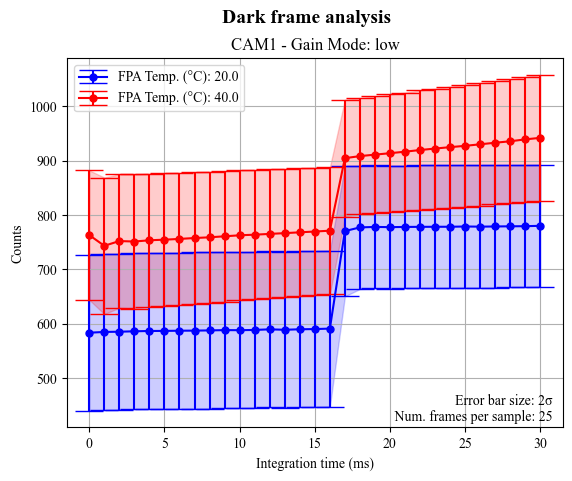

In [48]:
## LOW GAIN
runDarkFrameAnalysis("low", N=25)

In [46]:
cam.setSensorGain("low")
cam.setFPATempSetPoint(1)
cam.setIntTime(0.011)
print(np.std(cam.collectFrame(25)))

Running setup script - Gain Mode: low
Gain set to: low - Wellsize: 1380000.0 e-
Previous TEC parameters:
TEC is ON
FPA set point temperature (oC): 40
New TEC parameters:
TEC is ON
FPA set point temperature (oC): 20
Int. Time set to: 0.01ms Set-point: 20 - delta: 0.8 ...  
......................... 
154.60200869966772


Running setup script - Gain Mode: medium
Gain set to: medium - Wellsize: 118000.0 e-
Set FPA temp to 20oC
Previous TEC parameters:
TEC is ON
FPA set point temperature (oC): 40
New TEC parameters:
TEC is ON
FPA set point temperature (oC): 20
Set integration time to 0.011point: 20 - delta: 0.9 ...  
Int. Time set to: 0.01ms
......................... 
Num of dead pixels: 0
mean: 1052, std: 136
FPA actual temp: 19.7
 
Set integration time to 1.0
Int. Time set to: 1.00ms
......................... 
Num of dead pixels: 2
mean: 1029, std: 133
FPA actual temp: 20.0
 
Set integration time to 2.0
Int. Time set to: 2.00ms
......................... 
Num of dead pixels: 3
mean: 1027, std: 132
FPA actual temp: 19.9
 
Set integration time to 3.0
Int. Time set to: 3.00ms
......................... 
Num of dead pixels: 3
mean: 1030, std: 133
FPA actual temp: 20.0
 
Set integration time to 4.0
Int. Time set to: 4.00ms
......................... 
Num of dead pixels: 3
mean: 1034, std: 133
FPA actual temp: 2

/var/folders/t5/1zdfp4m52kqbs2csdsp2625c0000gn/T/ipykernel_59404/1298215418.py:71: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(intTime_ms, df_mean, yerr=df_std, label=f"FPA Temp. (\N{DEGREE SIGN}C): {cam.getFPAtemp()}", capsize=10, marker='o', markersize=5, fmt=marker[fpaTemp], color=color[fpaTemp])


Set FPA temp to 40oC
Previous TEC parameters:
TEC is ON
FPA set point temperature (oC): 20
New TEC parameters:
TEC is ON
FPA set point temperature (oC): 40
Set integration time to 0.011point: 40 - delta: -0.2 ...  
Int. Time set to: 0.01ms
......................... 
Num of dead pixels: 0
mean: 1243, std: 123
FPA actual temp: 42.2
 
Set integration time to 1.0
Int. Time set to: 1.00ms
......................... 
Num of dead pixels: 3
mean: 1209, std: 127
FPA actual temp: 39.1
 
Set integration time to 2.0
Int. Time set to: 2.00ms
......................... 
Num of dead pixels: 4
mean: 1238, std: 122
FPA actual temp: 40.4
 
Set integration time to 3.0
Int. Time set to: 3.00ms
......................... 
Num of dead pixels: 7
mean: 1258, std: 119
FPA actual temp: 39.9
 
Set integration time to 4.0
Int. Time set to: 4.00ms
......................... 
Num of dead pixels: 29
mean: 1277, std: 117
FPA actual temp: 40.1
 
Set integration time to 5.0
Int. Time set to: 5.00ms
........................

/var/folders/t5/1zdfp4m52kqbs2csdsp2625c0000gn/T/ipykernel_59404/1298215418.py:71: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-s" (-> marker='s'). The keyword argument will take precedence.
  ax.errorbar(intTime_ms, df_mean, yerr=df_std, label=f"FPA Temp. (\N{DEGREE SIGN}C): {cam.getFPAtemp()}", capsize=10, marker='o', markersize=5, fmt=marker[fpaTemp], color=color[fpaTemp])


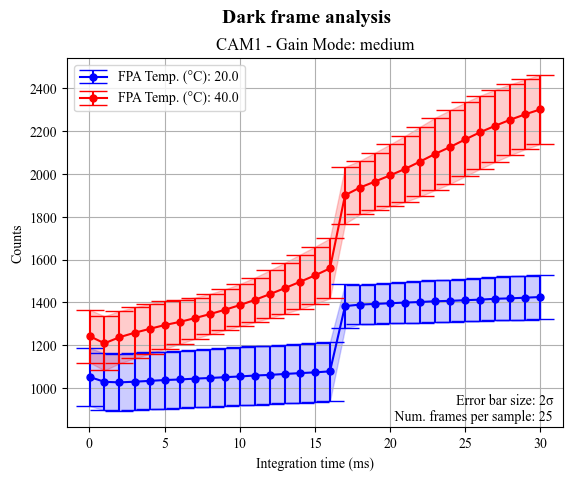

In [43]:
## Medium GAIN
runDarkFrameAnalysis("medium", N=25)

Running setup script - Gain Mode: high
Gain set to: high - Wellsize: 41000.0 e-
Set FPA temp to 20oC
Previous TEC parameters:
TEC is ON
FPA set point temperature (oC): 40
New TEC parameters:
TEC is ON
FPA set point temperature (oC): 20
Set integration time to 0.011point: 20 - delta: 1.1 ...  
Int. Time set to: 0.01ms
......................... 
Num of dead pixels: 0
mean: 1156, std: 197
FPA actual temp: 19.9
 
Set integration time to 1.0
Int. Time set to: 1.00ms
......................... 
Num of dead pixels: 3
mean: 955, std: 133
FPA actual temp: 19.9
 
Set integration time to 2.0
Int. Time set to: 2.00ms
......................... 
Num of dead pixels: 3
mean: 952, std: 131
FPA actual temp: 20.0
 
Set integration time to 3.0
Int. Time set to: 3.00ms
......................... 
Num of dead pixels: 4
mean: 962, std: 134
FPA actual temp: 20.0
 
Set integration time to 4.0
Int. Time set to: 4.00ms
......................... 
Num of dead pixels: 6
mean: 970, std: 136
FPA actual temp: 20.0
 
Set

/var/folders/t5/1zdfp4m52kqbs2csdsp2625c0000gn/T/ipykernel_59404/1298215418.py:71: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(intTime_ms, df_mean, yerr=df_std, label=f"FPA Temp. (\N{DEGREE SIGN}C): {cam.getFPAtemp()}", capsize=10, marker='o', markersize=5, fmt=marker[fpaTemp], color=color[fpaTemp])


Set FPA temp to 40oC
Previous TEC parameters:
TEC is ON
FPA set point temperature (oC): 20
New TEC parameters:
TEC is ON
FPA set point temperature (oC): 40
Set integration time to 0.011point: 40 - delta: 1.5 ...   
Int. Time set to: 0.01ms
......................... 
Num of dead pixels: 2
mean: 1290, std: 119
FPA actual temp: 40.0
 
Set integration time to 1.0
Int. Time set to: 1.00ms
......................... 
Num of dead pixels: 3
mean: 1176, std: 144
FPA actual temp: 39.6
 
Set integration time to 2.0
Int. Time set to: 2.00ms
......................... 
Num of dead pixels: 457
mean: 1251, std: 136
FPA actual temp: 40.3
 
Set integration time to 3.0
Int. Time set to: 3.00ms
......................... 
Num of dead pixels: 2308
mean: 1300, std: 115
FPA actual temp: 39.9
 
Set integration time to 4.0
Int. Time set to: 4.00ms
......................... 
Num of dead pixels: 2310
mean: 1360, std: 115
FPA actual temp: 40.1
 
Set integration time to 5.0
Int. Time set to: 5.00ms
.................

/var/folders/t5/1zdfp4m52kqbs2csdsp2625c0000gn/T/ipykernel_59404/1298215418.py:71: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-s" (-> marker='s'). The keyword argument will take precedence.
  ax.errorbar(intTime_ms, df_mean, yerr=df_std, label=f"FPA Temp. (\N{DEGREE SIGN}C): {cam.getFPAtemp()}", capsize=10, marker='o', markersize=5, fmt=marker[fpaTemp], color=color[fpaTemp])


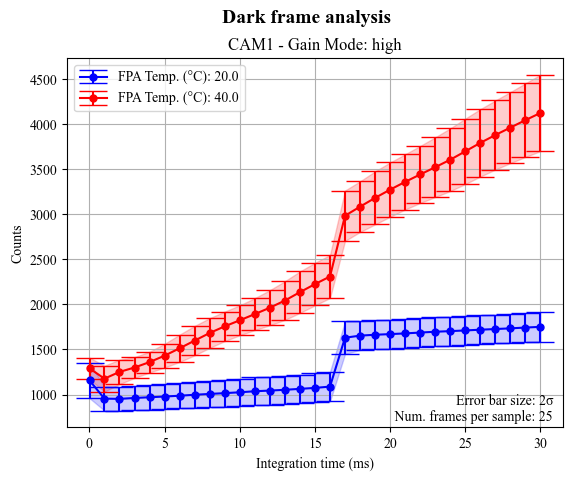

In [44]:
## High GAIN
runDarkFrameAnalysis("high", N=25)